In [42]:
import pandas as pd
import numpy as np
import seaborn as sns


from matplotlib import pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier


In [43]:
df = pd.read_csv('CreditScoring.csv')

In [57]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,good,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,good,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,bad,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,good,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,good,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910


<h5> Columns lower-case

In [44]:
df.columns = df.columns.str.lower()

 
<ul>Context:
<li>status: where the customer managed to pay back the loan (1) or not (2)
<li>seniority: job experience in years
<li>home: renting(1), homeowner(2), others
<li>time: period planned for the loan in months
<li>age
<li>marital[status]: single(1), married(2), others
<li>records: no(1), yes(2)
<li>job: fulltime (1), partime(2), others
<li>expenses: how much the client spends per month
<li>assets: total worth of all the assets of the client
<li>debt: amount of credit debt
<li>amount: requested amount of the load
<li>price: price of an item the client wants to buy 
</ul>



<h5>Pre-processing

In [45]:
"""
        values -> 
"""
status_values = {
    1: 'good',
    2: 'bad',
    0: 'unk'
}

df.status = df.status.map(status_values)
"""

"""
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'    
}

df.home = df.home.map(home_values)
"""

"""

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)
"""

"""
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

"""

"""
job_values = {
    1: 'fixed',
    2: 'parttime',
    3: 'freelance',
    4:'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [20]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [46]:
#Replacing the "99999999" values with Nan
for c in ['income','assets','debt']: 
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [62]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [22]:
df.status.value_counts()

status
good    3200
bad     1254
unk        1
Name: count, dtype: int64

In [47]:
#Only 1 row with value "unk", will delete

df = df[df.status != 'unk']

<h2>Data set Preparation

In [48]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [74]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [25]:
df_train.shape, df_val.shape

((2672, 14), (891, 14))

In [8]:
#Selecting the target variable for training the model

y_train = (df_train.status == 'bad').values     #compara todos los elementos de la col "status" si son iguales a default, resultando un bool.
y_val = (df_val.status == 'bad').values         #queremos saber la prediccion de que alguien no pueda pagar el prestamo

del df_train['status']
del df_val['status']

In [9]:
#Filling NaNs

df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

In [10]:
#Dict-Vectorizer

dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient= 'records')

In [11]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)      #fit solo es necesario una vez, ya que dv ya ha aprendido
X_val = dv.transform(dict_val)

<h4> Training the Decision tree model

In [30]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [31]:
#Evaluating the performance
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)
"""
The model is overfitting
"""

'\nThe model is overfitting\n'

In [32]:
y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.6538652490857573

<h4> Treating overfit

In [33]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [34]:
#visualizing the tree

tree_text = export_text(dt, feature_names=dv.feature_names_)
print(tree_text)

|--- records=yes <= 0.50
|   |--- job=parttime <= 0.50
|   |   |--- class: False
|   |--- job=parttime >  0.50
|   |   |--- class: True
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False



In [35]:
y_pred = dt.predict_proba(X_train)[:,1]
auc= roc_auc_score(y_train, y_pred)
print(auc)

y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val,y_pred)
print(auc)


0.7054989859726213
0.6685264343319367


<h4> Finding the best parameters 

In [36]:
for m in [4,5,6]:
    print('depth: %s' % m)
    
    for s in [1,5,10,15,20,50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth = m, min_samples_leaf= s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))
    print()

depth: 4
1 -> 0.761
5 -> 0.761
10 -> 0.761
15 -> 0.764
20 -> 0.761
50 -> 0.753
100 -> 0.756
200 -> 0.747

depth: 5
1 -> 0.767
5 -> 0.768
10 -> 0.762
15 -> 0.772
20 -> 0.774
50 -> 0.767
100 -> 0.763
200 -> 0.759

depth: 6
1 -> 0.750
5 -> 0.762
10 -> 0.778
15 -> 0.785
20 -> 0.774
50 -> 0.770
100 -> 0.776
200 -> 0.768



In [38]:
# best parameters are max_depth = 6, min_leafs = 15 with auc of 78.5% 
#training the model
dt = DecisionTreeClassifier(max_depth= 6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

<h2> Random Forest

In [51]:
rf = RandomForestClassifier(n_estimators=10, random_state= 3)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=3)

In [52]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)


0.7811145285897654

In [64]:
#finding the best number of 'forests'

aucs = []

for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))

    aucs.append(auc)

10 -> 0.781
20 -> 0.801
30 -> 0.813
40 -> 0.815
50 -> 0.816
60 -> 0.817
70 -> 0.818
80 -> 0.818
90 -> 0.820
100 -> 0.819
110 -> 0.819
120 -> 0.821
130 -> 0.822
140 -> 0.822
150 -> 0.820
160 -> 0.820
170 -> 0.819
180 -> 0.820
190 -> 0.820
200 -> 0.820


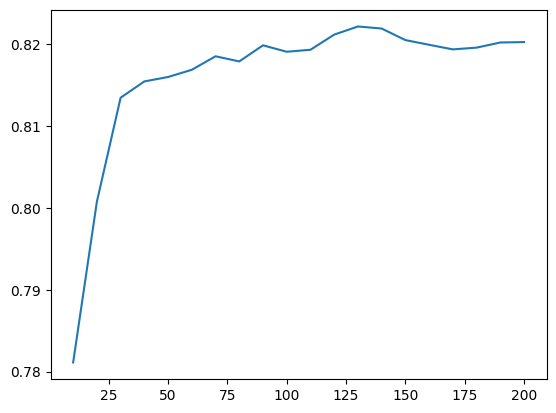

In [62]:
plt.plot(range(10,201,10), aucs)


In [66]:
"""
We can see that the best number of estimators is around 130, from where it starts to decrease
Now we need the tuning of the normal decision tree, using max_depth and min_leaf_size
"""

all_aucs = {}

for depth in [5,10,20]:
    print('depth: %s ' % depth)
    auc=[]

    for i in range(10,201,10):
        rf = RandomForestClassifier(n_estimators = i, max_depth = depth, random_state= 1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' %(i, auc))
        aucs.append(auc)
    all_aucs[depth] = aucs
    print()

depth: 5 
10 -> 0.788
20 -> 0.798
30 -> 0.800
40 -> 0.800
50 -> 0.800
60 -> 0.801
70 -> 0.802
80 -> 0.803
90 -> 0.804
100 -> 0.804
110 -> 0.807
120 -> 0.806
130 -> 0.808
140 -> 0.807
150 -> 0.807
160 -> 0.807
170 -> 0.807
180 -> 0.807
190 -> 0.807
200 -> 0.807

depth: 10 
10 -> 0.791
20 -> 0.808
30 -> 0.812
40 -> 0.818
50 -> 0.817
60 -> 0.819
70 -> 0.820
80 -> 0.820
90 -> 0.820
100 -> 0.821
110 -> 0.823
120 -> 0.823
130 -> 0.825
140 -> 0.824
150 -> 0.824
160 -> 0.825
170 -> 0.825
180 -> 0.825
190 -> 0.825
200 -> 0.825

depth: 20 
10 -> 0.776
20 -> 0.803
30 -> 0.813
40 -> 0.817
50 -> 0.815
60 -> 0.813
70 -> 0.814
80 -> 0.815
90 -> 0.814
100 -> 0.815
110 -> 0.817
120 -> 0.816
130 -> 0.818
140 -> 0.818
150 -> 0.818
160 -> 0.818
170 -> 0.817
180 -> 0.817
190 -> 0.817
200 -> 0.818



In [67]:
"""
we can see that using a depth of 10, we get the best result around the 130 estimators
now we need to look for the min_leaf_size
"""

all_aucs = {}

for m in [3,5,10]:
    print('min_leaf_size: %s ' % m)
    auc=[]

    for i in range(10,201,10):
        rf = RandomForestClassifier(n_estimators = i, max_depth = 10, min_samples_leaf= m, random_state= 1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' %(i, auc))
        aucs.append(auc)
    all_aucs[depth] = aucs
    print()

min_leaf_size: 3 
10 -> 0.811
20 -> 0.820
30 -> 0.823
40 -> 0.822
50 -> 0.823
60 -> 0.823
70 -> 0.822
80 -> 0.823
90 -> 0.823
100 -> 0.823
110 -> 0.823
120 -> 0.825
130 -> 0.824
140 -> 0.825
150 -> 0.825
160 -> 0.826
170 -> 0.825
180 -> 0.825
190 -> 0.825
200 -> 0.825

min_leaf_size: 5 
10 -> 0.813
20 -> 0.815
30 -> 0.818
40 -> 0.820
50 -> 0.821
60 -> 0.823
70 -> 0.822
80 -> 0.823
90 -> 0.822
100 -> 0.824
110 -> 0.825
120 -> 0.825
130 -> 0.825
140 -> 0.824
150 -> 0.825
160 -> 0.825
170 -> 0.825
180 -> 0.825
190 -> 0.826
200 -> 0.825

min_leaf_size: 10 
10 -> 0.810
20 -> 0.818
30 -> 0.822
40 -> 0.822
50 -> 0.822
60 -> 0.822
70 -> 0.819
80 -> 0.820
90 -> 0.820
100 -> 0.819
110 -> 0.820
120 -> 0.820
130 -> 0.821
140 -> 0.820
150 -> 0.820
160 -> 0.820
170 -> 0.820
180 -> 0.820
190 -> 0.820
200 -> 0.820



<h3> Training the final model</h3><br>
<ul>with: <br> 
<li>min_leaf_size = 5
<li>n_estimators = 200
<li>max_depth = 10

In [12]:
rt = RandomForestClassifier(n_estimators=200, max_depth = 10, min_samples_leaf= 5, random_state= 1)

<h3> XGBoost

In [14]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)       #(feature_matrix, target variable, names of the feautures in X)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

In [15]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',         #specifies the learning task
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

In [26]:
#training the model with 10 trees
model = xgb.train(xgb_params, dtrain, num_boost_round= 10)

c:\Users\oliva\Documents\GitHub\ML-Projects\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [10:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [27]:
y_pred = model.predict(dval)
y_pred[:10]

array([0.07751459, 0.07131889, 0.0675393 , 0.12096145, 0.05379206,
       0.06382526, 0.06665564, 0.4352498 , 0.41923273, 0.02550563],
      dtype=float32)

In [28]:
roc_auc_score(y_val, y_pred)

0.8065256351262986

<h5>  XGBoost performance monitoring

In [34]:
#Adding a watchlist to get an idea of how AUC changes as the number of trees grows
watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',         #specifies the learning task
    'eval_metric':'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

#we need to add 2 extra arguments for the train function
#evals -> watchlist
#verbose_eval -> how often we print the metric

model = xgb.train (xgb_params, dtrain,
                   num_boost_round = 100,
                   evals= watchlist, verbose_eval=10)

[0]	train-auc:0.86730	val-auc:0.77938
[10]	train-auc:0.95447	val-auc:0.80851


c:\Users\oliva\Documents\GitHub\ML-Projects\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:37:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	train-auc:0.97464	val-auc:0.81729
[30]	train-auc:0.98579	val-auc:0.81543
[40]	train-auc:0.99421	val-auc:0.80922
[50]	train-auc:0.99653	val-auc:0.80918
[60]	train-auc:0.99817	val-auc:0.81172
[70]	train-auc:0.99934	val-auc:0.80870
[80]	train-auc:0.99979	val-auc:0.80549
[90]	train-auc:0.99993	val-auc:0.80409
[99]	train-auc:0.99999	val-auc:0.80560


In [36]:
#smaller ETA

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,         #changing from 6 to 3
    'min_child_weight': 1,

    'objective': 'binary:logistic',         #specifies the learning task
    'eval_metric':'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}
model = xgb.train (xgb_params, dtrain,
                   num_boost_round = 500,
                   evals= watchlist, verbose_eval=10)

[0]	train-auc:0.77610	val-auc:0.73891
[10]	train-auc:0.84675	val-auc:0.78896


[20]	train-auc:0.86931	val-auc:0.80928


c:\Users\oliva\Documents\GitHub\ML-Projects\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:59:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	train-auc:0.88080	val-auc:0.81808
[40]	train-auc:0.89038	val-auc:0.82347
[50]	train-auc:0.89756	val-auc:0.82583
[60]	train-auc:0.90319	val-auc:0.82847
[70]	train-auc:0.90768	val-auc:0.83005
[80]	train-auc:0.91221	val-auc:0.83117
[90]	train-auc:0.91638	val-auc:0.83029
[100]	train-auc:0.91913	val-auc:0.83113
[110]	train-auc:0.92297	val-auc:0.83170
[120]	train-auc:0.92544	val-auc:0.83124
[130]	train-auc:0.92789	val-auc:0.83169
[140]	train-auc:0.92996	val-auc:0.83088
[150]	train-auc:0.93200	val-auc:0.83108
[160]	train-auc:0.93416	val-auc:0.83154
[170]	train-auc:0.93638	val-auc:0.83129
[180]	train-auc:0.93842	val-auc:0.83046
[190]	train-auc:0.94005	val-auc:0.83014
[200]	train-auc:0.94181	val-auc:0.82986
[210]	train-auc:0.94374	val-auc:0.82907
[220]	train-auc:0.94529	val-auc:0.82902
[230]	train-auc:0.94725	val-auc:0.82884
[240]	train-auc:0.94840	val-auc:0.82846
[250]	train-auc:0.94951	val-auc:0.82877
[260]	train-auc:0.95073	val-auc:0.82834
[270]	train-auc:0.95199	val-auc:0.82806
[280]	t

<h4> Final model

In [49]:
y_train = (df_train_full.status == 'bad').values
y_test = (df_test.status == 'bad').values

del df_train_full['status']
del df_test['status']

#to dictionary for one-hot-encoding

dict_train = df_train_full.fillna(0).to_dict(orient='records')
dict_test = df_test.fillna(0).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_test = dv.transform(dict_test)

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names= dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)


xgb_params = {
    'eta': 0.1,
    'max_depth': 3,         
    'min_child_weight': 1,

    'objective': 'binary:logistic',   
    'eval_metric':'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

num_trees = 160

model = xgb.train(xgb_params, dtrain, num_boost_round=num_trees)




c:\Users\oliva\Documents\GitHub\ML-Projects\.venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:10:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [50]:
#Evaluating

y_pred_xgb = model.predict(dtest)
roc_auc_score(y_test, y_pred_xgb)

0.5134188211719857